In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score

In [7]:
# for loading bars on notebook
from tqdm import tqdm

# Set random seed
SEED = 385433  # my G number
np.random.seed(SEED)


In [ ]:

# Define dataset path
DATASET_PATH = "fashion"
CATEGORIES = ['ankleboot', 'bag']
CATEGORIES = ['ankleboot', 'bag', 'coat', 'dress', 'pullover', 'sandal', 'shirt', 'sneaker', 'trouser', 'tshirt-top']

# Load images and labels with progress bar
X, y = [], []
for label, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_PATH, category)
    files = os.listdir(folder_path)
    for file in tqdm(files, desc=f"Loading {category}"):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img_resized = img.resize((28, 28))  # Resize to 28x28
        X.append(np.array(img_resized).flatten())  # Flatten images
        y.append(label)

X = np.array(X)
y = np.array(y)

print('Read in dataset')

Loading tshirt-top:  36%|█████████████████████                                     | 2535/7000 [00:24<00:51, 86.57it/s]

Dataset Shape: (14000, 784)
Labels Distribution:
0    7000
1    7000
Name: count, dtype: int64


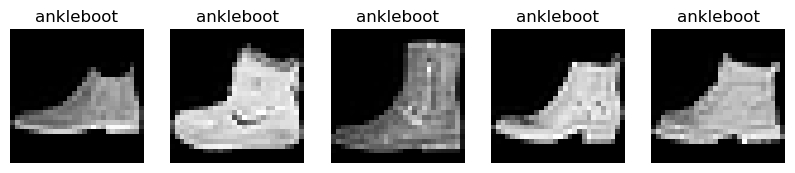

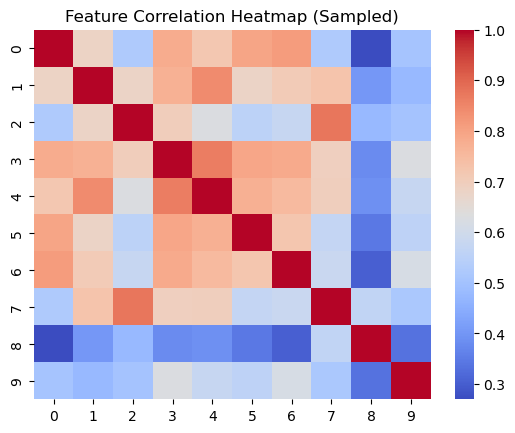

Checking for data leakage...
Training Set: (8960, 784) (8960,)
Validation Set: (2240, 784) (2240,)
Test Set: (2800, 784) (2800,)
Splitting dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4123.50it/s]


Using multiple models to compare performance:
- SVM: Effective for high-dimensional data.
- Logistic Regression: A baseline linear classifier.
- Random Forest: A powerful ensemble model handling nonlinear relationships.
Training models...


Model Training:  33%|██████████████████████▋                                             | 1/3 [00:00<00:01,  1.14it/s]


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1120
           1       1.00      0.99      1.00      1120

    accuracy                           1.00      2240
   macro avg       1.00      1.00      1.00      2240
weighted avg       1.00      1.00      1.00      2240



Model Training:  67%|█████████████████████████████████████████████▎                      | 2/3 [00:02<00:01,  1.05s/it]


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1120
           1       1.00      0.99      1.00      1120

    accuracy                           1.00      2240
   macro avg       1.00      1.00      1.00      2240
weighted avg       1.00      1.00      1.00      2240



Model Training: 100%|████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.67s/it]


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1120
           1       1.00      1.00      1.00      1120

    accuracy                           1.00      2240
   macro avg       1.00      1.00      1.00      2240
weighted avg       1.00      1.00      1.00      2240


Model Performance:
                     Accuracy       MSE        R2
SVM                  0.996875  0.003125  0.987500
Logistic Regression  0.996875  0.003125  0.987500
Random Forest        0.998214  0.001786  0.992857


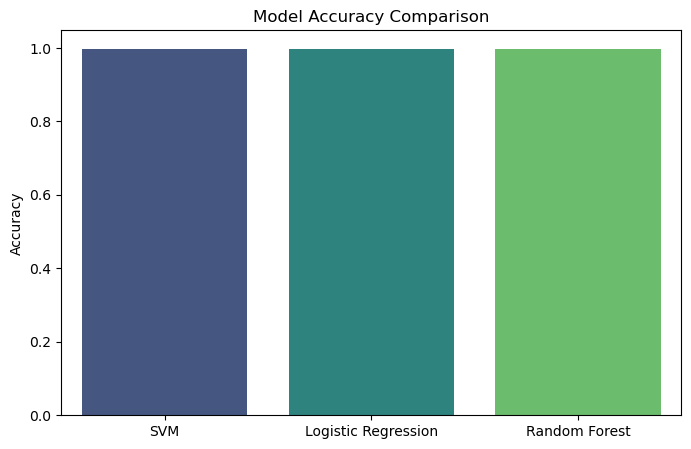

Evaluating best model on test set...

Best Model: Random Forest
Test Set Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1400
           1       1.00      1.00      1.00      1400

    accuracy                           1.00      2800
   macro avg       1.00      1.00      1.00      2800
weighted avg       1.00      1.00      1.00      2800



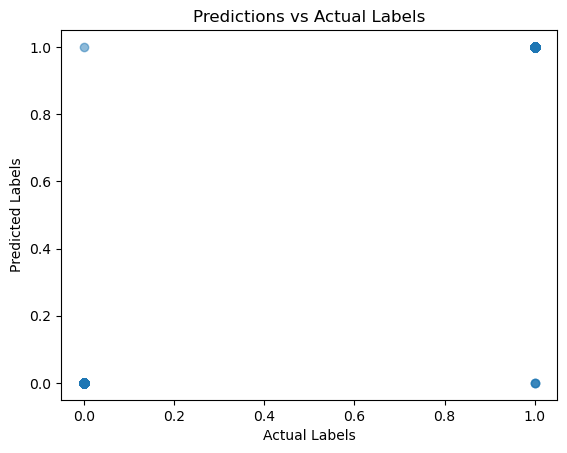

In [9]:
# Examine dataset
print("Dataset Shape:", X.shape)
print("Labels Distribution:")
print(pd.Series(y).value_counts())

# Display some sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(CATEGORIES[y[i]])
    ax.axis('off')
plt.show()

# Correlation check (adapted from linear regression lab)
corr_matrix = np.corrcoef(X[:1000])  # Sampled for efficiency
sns.heatmap(corr_matrix[:10, :10], cmap='coolwarm')
plt.title("Feature Correlation Heatmap (Sampled)")
plt.show()

# Check for data leakage
print("Checking for data leakage...")
print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Split into training, validation, and test sets with progress bar
print("Splitting dataset...")
with tqdm(total=100) as pbar:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True, stratify=y)
    pbar.update(50)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, shuffle=True, stratify=y_train)
    pbar.update(50)

# Justification for model choices (inspired by lab rationale)
print("Using multiple models to compare performance:")
print("- SVM: Effective for high-dimensional data.")
print("- Logistic Regression: A baseline linear classifier.")
print("- Random Forest: A powerful ensemble model handling nonlinear relationships.")

# Initialize models
models = {
    "SVM": SVC(kernel='linear', random_state=SEED),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=SEED)
}

# Train and evaluate models with progress bar
results = {}
print("Training models...")
for name, model in tqdm(models.items(), desc="Model Training"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    mse_val = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    results[name] = {"Accuracy": acc, "MSE": mse_val, "R2": r2}
    print(f"\n{name} Classification Report:\n", classification_report(y_val, y_pred))
    
# Compare results
results_df = pd.DataFrame(results).T
print("\nModel Performance:")
print(results_df)
plt.figure(figsize=(8, 5))
sns.barplot(x=results_df.index, y=results_df["Accuracy"], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# Final Evaluation on Test Set
print("Evaluating best model on test set...")
best_model_name = results_df["Accuracy"].idxmax()
best_model = models[best_model_name]
y_test_pred = best_model.predict(X_test)

print(f"\nBest Model: {best_model_name}")
print("Test Set Classification Report:\n", classification_report(y_test, y_test_pred))

# Regression-style visualization (from lab inspiration)
plt.scatter(y_val, models[best_model_name].predict(X_val), alpha=0.5)
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")
plt.title("Predictions vs Actual Labels")
plt.show()